# Model Criticism for Bayesian Causal Inference


## Imports <a class="anchor" id="imports21"></a>

In [1]:
import os
os.chdir('/Users/lguelman/Library/Mobile Documents/com~apple~CloudDocs/LG_Files/Development/MCBCI/python')

import numpy as np
import pandas as pd
import scipy.stats as stats
import math

import matplotlib.pyplot as plt
parameters = {'figure.figsize': (8, 4),
              'font.size': 6, 
              'axes.labelsize': 10}
plt.rcParams.update(parameters)
plt.style.use('fivethirtyeight')
from IPython.display import Image

import pystan
import multiprocessing
import stan_utility
import arviz as az

import seaborn as sns
from utils import stan_model_summary, DataGeneratingProcess

## 1. Generate Syntehic Data 

We generate synthetic data according to Section 4.1 of the [paper](https://arxiv.org/abs/1610.09037). Specifically, we generate 10,000 data points, each with a 10-dimensional covariate $x_i$, a binary treatment $a_i$, and a set of potential outcomes $(y_i(0), y_i(1))$,

\begin{align*} 
x_i &\sim  \text{Uniform}\big(x_i~\vert~[0,1]^{10} \big), \\ 
a_i~\vert~x_i &\sim \text{Bernoulli} \big(a_i~\vert~ \text{logistic}(x_i^\intercal \phi)  \big) \\
y_i(a)~\vert~x_i &\sim \mathscr{N} \big(y_i(a)~\vert~[x_i,a]^\intercal \theta, \sigma^2  \big) \\
\phi, \theta &\sim \mathscr{N}(0,1) \\
\sigma^2 &\sim \text{Gamma}(1,1) \\
\end{align*}

We further assume zero correlation $\rho$ between potential outcome. This can be modified by changing  the parameter `rho` in the code below. 

In [2]:
dgp = DataGeneratingProcess(N=10000, d=10, rho=0.0, seed=432)
data = dgp.generate_data()
data.df

,y_obs,y_mis,y0,y1,tau_unit,a,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,-2.282170,-1.751866,-1.751866,-2.282170,-0.530304,1,0.903661,0.896010,0.589950,0.987273,0.851603,0.208817,0.766623,0.032806,0.296746,0.570360
1,1.401592,2.379974,1.401592,2.379974,0.978382,0,0.834669,0.160730,0.348411,0.030891,0.986353,0.501477,0.437794,0.652700,0.470989,0.948481
2,1.876295,1.700667,1.700667,1.876295,0.175629,1,0.587839,0.020352,0.817677,0.977189,0.177341,0.849895,0.906638,0.699583,0.717297,0.576994
3,0.290883,0.906343,0.906343,0.290883,-0.615460,1,0.398804,0.246183,0.523785,0.471349,0.020301,0.634659,0.927902,0.888842,0.703946,0.204001
4,0.000142,-0.131812,-0.131812,0.000142,0.131954,1,0.836528,0.774359,0.919492,0.569234,0.779445,0.185953,0.868888,0.660685,0.276374,0.231046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.373833,0.864444,-0.373833,0.864444,1.238277,0,0.333860,0.390751,0.512962,0.043840,0.122322,0.427528,0.543614,0.305593,0.797372,0.883533
9996,0.150197,0.577718,0.577718,0.150197,-0.427521,1,0.080487,0.388663,0.188018,0.654966,0.718935,0.044967,0.819145,0.152824,0.001095,0.086726
9997,-0.154712,-0.332299,-0.154712,-0.332299,-0.177586,0,0.163805,0.711616,0.171477,0.559514,0.743730,0.337349,0.285183,0.240291,0.405679,0.400154
9998,0.549524,-0.745914,0.549524,-0.745914,-1.295438,0,0.138004,0.535739,0.843811,0.936051,0.343995,0.242747,0.823671,0.664397,0.342180,0.165053


## 2. Model-Based Inference 

We approximate the posterior with MCMC in [Stan](https://mc-stan.org/) under three alternative causal models. We obtain 2000 samples from the posterior of all variables in the causal model: $y(0),~y(1),~\mathbf{a},~\phi,~\theta,~ \text{and}~\sigma^2$. The correlation between potential outcomes, $\rho$, is the only parameter about which the observed data cannot provide empirical information becuase $y_i(0)$ and $y_i(1)$ are never observed simultaneously. Thus, model-based inference requires subject-matter knowledge and sensible assumptions on the joint distribution of potential outcomes.

There are two sources of uncertainty in the posterior predictive distribution of the missing potential outcomes $P(y^{\text{miss}} | y^{\text{obs}}, a)$. The first is the uncertainty in the estimated latent variables $\theta, ~\sigma^2$ (a.k.a., *epistemic uncertainty*). The second is the uncertainty in the data as expressed by the Gaussian random sampling mechanism (a.k.a., *aleatoric uncertainty*). The same holds for the posterior predictive distribution of the treatment assignment, with epistemic uncertainty being determined by the posterior distribution $P(\phi|x, y(\mathbf{a}), \mathbf{a})$, and aleatoric uncertainty determined by the Bernoulli random sampling process $P(\mathbf{a}|x, \phi)$. 


### 2.1. Case A: The Correct Model

Assume we implement a model that is faithful to the specification outlined in Section 1.

In [3]:
stan_data_dict = {'N': data.N,       # sample size
                  'd_a': data.d,     # number of covariates in the assignment model
                  'd_o': data.d,     # number of covariates in the outcome model
                  'X_a': data.X,     # covariates matrix for assignment model
                  'X_o': data.X,     # covariates matrix for outcome model  
                  'y': data.y_obs,   # observed outcome
                  'a': data.a,       # treatment assigned
                  'rho': 0.0,        # correlation between the potential outcomes (assumed)
                  'a_miss':0,        # assignment model misspecified (1), or not (0). 
                  }

sm = pystan.StanModel('../stan/mbi_stan.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_a = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43897455de0347d6cdff2741a5d2fe97 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### 2.2. Case B: Misspecified Outcome Model

Assume we misspecify the distribution over $y_i(a)$ by ignoring the first entry on $x_i$ (i.e., $\theta_1=0$).

In [4]:
stan_data_dict_b = {'N': data.N,
                    'd_a': data.d,
                    'd_o': data.d-1,
                    'X_a': data.X,
                    'X_o': data.X[:,1:10],
                    'y': data.y_obs,
                    'a': data.a,
                    'rho': 0.0,
                    'a_miss':0,
                   }

sm_b = pystan.StanModel('../stan/mbi_stan.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_b = sm_b.sampling(data=stan_data_dict_b, iter=1000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43897455de0347d6cdff2741a5d2fe97 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### 2.3. Case C: Misspecified Assignment Model

Assume we misspecify the distribution over $a_i$ by setting the probability that $a_i=1$ to: $~0.7+0.3 \times \text{logistic}(x_i^\intercal \phi)$.



In [5]:
stan_data_dict_c = {'N': data.N,
                    'd_a': data.d,
                    'd_o': data.d,
                    'X_a': data.X,
                    'X_o': data.X,
                    'y': data.y_obs,
                    'a': data.a,
                    'rho': 0.0,
                    'a_miss':1,
                    }


In [6]:
sm_c = pystan.StanModel('../stan/mbi_stan.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_c = sm_c.sampling(data=stan_data_dict_c, iter=1000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43897455de0347d6cdff2741a5d2fe97 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 3. Model Criticism 

Model criticism measures the degree to which a model falsely describes the data. The central tool for this is the posterior predictive check (PPC). It quantifies the degree to which data generated from the model deviate from the observe data.

### 3.1. Criticizing the Assignment Model

We plot below the *reference discrepancy* vs. *realized discrepancy*. We've used mean probability of assignment instead of log-likelihood (used in the paper) as the discrepancy function.

The test for the correct assignment model does not suggest any issue, but with the "wrong"  model, the test fails. This correctly indicates that we should revise the model. 

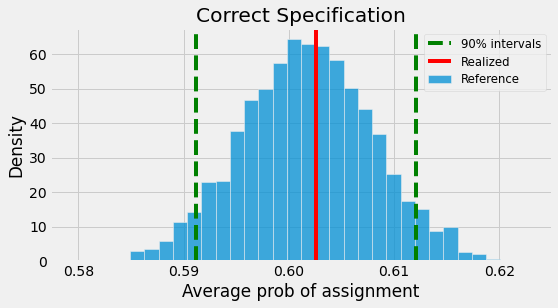

In [7]:
samples_a = fit_a.extract(permuted=True)

#p_phi_a = samples_a['phi']
p_a_rep_a = samples_a['a_rep']

p = sns.histplot(data=np.mean(p_a_rep_a, axis=1), stat="density", label="Reference") 
p.set(xlabel='Average prob of assignment', title='Correct Specification')
plt.axvline(np.quantile(np.mean(p_a_rep_a, axis=1), .05), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(np.mean(p_a_rep_a, axis=1), .95), color='g', linestyle='--')
plt.axvline(np.mean(data.a), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')

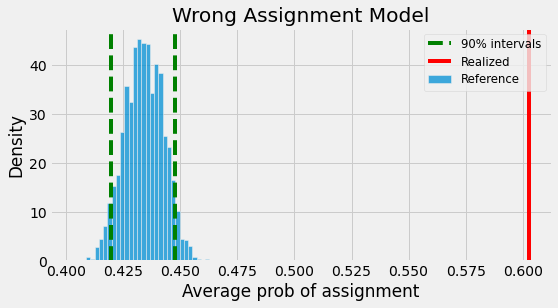

In [8]:
samples_c = fit_c.extract(permuted=True)

#p_phi_c = samples_c['phi']
p_a_rep_c = samples_c['a_rep']

p = sns.histplot(data=np.mean(p_a_rep_c, axis=1), stat="density", label="Reference")
p.set(xlabel='Average prob of assignment', title='Wrong Assignment Model')
plt.axvline(np.quantile(np.mean(p_a_rep_c, axis=1), .05), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(np.mean(p_a_rep_c, axis=1), .95), color='g', linestyle='--')
plt.axvline(np.mean(data.a), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')

### 3.1. Criticizing the Outcome Model

#### 3.1.1. "Science-Fiction" scenario: Assume access to counterfactual outcomes

We display the reference distribution for the average unit-level treatment effect computed from samples from the posterior predictive distribution of potential outcomes. The realized discrepancy is given by the actual average treatment (which is not accessible in real-world scenario).

Again, as expected the test fails for the case in which the outcome model is misspecified. 

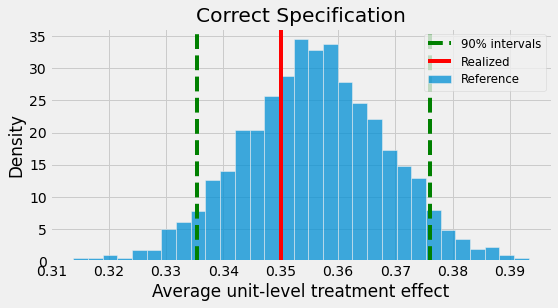

In [9]:
#Reference distribution for unit-level treatment effect
p = sns.histplot(data=np.mean(samples_a['tau_unit'], axis=1), stat="density", 
                 label="Reference")
p.set(xlabel='Average unit-level treatment effect', title='Correct Specification')
plt.axvline(np.quantile(np.mean(samples_a['tau_unit'], axis=1), .05), 
            color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(np.mean(samples_a['tau_unit'], axis=1), .95),
            color='g', linestyle='--')

# Realized discrepancy for unit-level treatment effect
plt.axvline(np.mean(data.df.tau_unit.values), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')

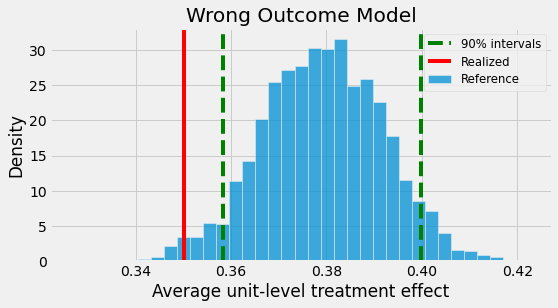

In [10]:
samples_b = fit_b.extract(permuted=True) # misspecified outcome model
#Reference distribution for unit-level treatment effect
p = sns.histplot(data=np.mean(samples_b['tau_unit'], axis=1), stat="density", label="Reference")
p.set(xlabel='Average unit-level treatment effect', title='Wrong Outcome Model')
plt.axvline(np.quantile(np.mean(samples_b['tau_unit'], axis=1), .05), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(np.mean(samples_b['tau_unit'], axis=1), .95), color='g', linestyle='--')
# Realized discrepancy for unit-level treatment effect
plt.axvline(np.mean(data.df.tau_unit.values), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')

#### 3.1.2. "Fiction" scenario: Assume access to factual outcomes only

The test does not fail for the model in which the outcome model is misspecified. 

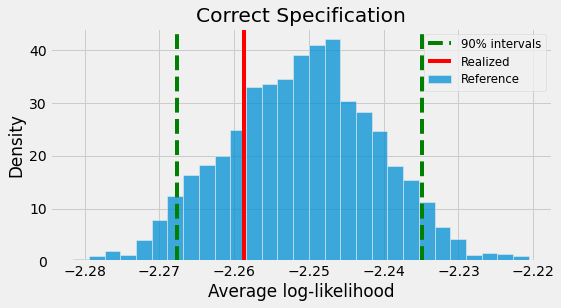

In [11]:
# Reference distribution - Average log-likelihood of potential outcomes

ref_dist = np.mean(samples_a['log_lik_ref_y0'].T + 
                   samples_a['log_lik_ref_y1'].T, axis=0)
p = sns.histplot(data=ref_dist, stat="density", label="Reference")
p.set(xlabel='Average log-likelihood', title='Correct Specification')
plt.axvline(np.quantile(ref_dist, .05), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(ref_dist, .95), color='g', linestyle='--')

# Realized discrepancy
pi = samples_a['a_prob'].T 
weighted_log_lik_y_obs = np.zeros(shape=(samples_a['log_lik_y_obs'].T.shape))
for i in range(len(data.a)):
    if data.a[i] == 0:
        weighted_log_lik_y_obs[i, :]=samples_a['log_lik_y_obs'].T[i,:]/(1-pi[i,:])
    else:
        weighted_log_lik_y_obs[i, :]=samples_a['log_lik_y_obs'].T[i,:]/(pi[i,:])
plt.axvline(np.mean(weighted_log_lik_y_obs), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')

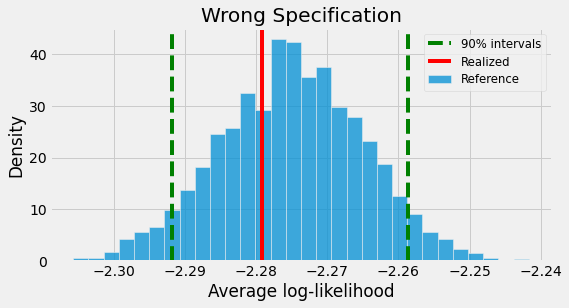

In [12]:
# Reference distribution - Average log-likelihood of potential outcomes

ref_dist = np.mean(samples_b['log_lik_ref_y0'].T + 
                   samples_b['log_lik_ref_y1'].T, axis=0)
p = sns.histplot(data=ref_dist, stat="density", label="Reference")
p.set(xlabel='Average log-likelihood', title='Wrong Specification')
plt.axvline(np.quantile(ref_dist, .05), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(ref_dist, .95), color='g', linestyle='--')

# Realized discrepancy 
pi = samples_b['a_prob'].T 
weighted_log_lik_y_obs = np.zeros(shape=(samples_b['log_lik_y_obs'].T.shape))
for i in range(len(data.a)):
    if data.a[i] == 0:
        weighted_log_lik_y_obs[i, :]=samples_b['log_lik_y_obs'].T[i,:]/(1-pi[i,:])
    else:
        weighted_log_lik_y_obs[i, :]=samples_b['log_lik_y_obs'].T[i,:]/(pi[i,:])
plt.axvline(np.mean(weighted_log_lik_y_obs), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')